In [1]:
import os
import json
from easydict import EasyDict as edict
import sys
import time
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets.brain import BrainProcessor, BrainMulti
from datasets.slice.transforms import make_mri_transforms, make_pet_transforms
from models.slice.build import build_networks_general_teacher

from utils.gpu import set_gpu

import matplotlib.pyplot as plt

In [2]:
hash = "2023-05-02_18-06-46"
# hash = "2023-05-03_15-51-38"
local_rank = 0

In [3]:
config = os.path.join(f'../checkpoints/GeneralTeacher-FBP/{hash}/configs.json')
with open(config, 'rb') as fb:
    config = json.load(fb)

config = edict(config)
config.model_param = os.path.join(f'../checkpoints/GeneralTeacher-FBP/{hash}/ckpt.best.pth.tar')

In [4]:
set_gpu(config)
np.random.seed(config.random_state)
torch.manual_seed(config.random_state)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True

torch.cuda.set_device(local_rank)

In [5]:
# Data
train_transform_mri, test_transform_mri = make_mri_transforms(
        image_size_mri=config.image_size_mri, intensity_mri=config.intensity_mri, crop_size_mri=config.crop_size_mri,
        rotate_mri=config.rotate_mri, flip_mri=config.flip_mri, affine_mri=config.affine_mri,
        blur_std_mri=config.blur_std_mri, train_slices=config.train_slices, num_slices=config.num_slices,
        slice_range=config.slice_range, prob=config.prob)
train_transform_pet, test_transform_pet = make_pet_transforms(
    image_size_pet=config.image_size_pet, intensity_pet=config.intensity_pet, crop_size_pet=config.crop_size_pet,
    rotate_pet=config.rotate_pet, flip_pet=config.flip_pet, affine_pet=config.affine_pet,
    blur_std_pet=config.blur_std_pet, train_slices=config.train_slices, num_slices=config.num_slices,
    slice_range=config.slice_range, prob=config.prob)

processor = BrainProcessor(root=config.root,
                               data_file=config.data_file,
                               mri_type=config.mri_type,
                               pet_type=config.pet_type,
                               mci_only=config.mci_only,
                               random_state=config.random_state)
datasets_dict = processor.process(validation_size=config.validation_size,
                                  test_size=config.test_size,
                                  missing_rate=config.missing_rate)

train_set = BrainMulti(dataset=datasets_dict['mri_pet_complete_train'],
                           mri_transform=train_transform_mri,
                           pet_transform=train_transform_pet)
validation_set = BrainMulti(dataset=datasets_dict['mri_pet_complete_validation'],
                            mri_transform=test_transform_mri,
                            pet_transform=test_transform_pet)
test_set = BrainMulti(dataset=datasets_dict['mri_pet_complete_test'],
                      mri_transform=test_transform_mri,
                      pet_transform=test_transform_pet)

datasets = {'train': train_set, 'validation': validation_set, 'test': test_set}

C:\Users\mingu\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
# Networks
# config.encoder_act = 'relu'
networks = build_networks_general_teacher(config=config)
networks = {k: v for k, v in networks.items() if v is not None}

ckpt = torch.load(config.model_param, map_location='cpu')

for name, network in networks.items():
    network.load_state_dict(ckpt[name])
    network.to(local_rank)
    network.eval()

In [8]:
train_loader = DataLoader(dataset=datasets['train'], batch_size=config.batch_size, drop_last=False)

In [9]:
Z = {'z_mri_general': [],
     'z_pet_general': [],
     'z_mri': [],
     'z_pet': [],
     'y': []}

with torch.no_grad():
    for batch in tqdm.tqdm(train_loader):
        # input data
        x_mri = torch.concat(batch['mri']).float().to(local_rank)
        x_pet = torch.concat(batch['pet']).float().to(local_rank)
        y = batch['y'].long().repeat(config.num_slices).to(local_rank)

        # hidden representations - h
        if config.use_projector:
            h_mri = networks['projector_mri'](networks['extractor_mri'](x_mri))
            h_pet = networks['projector_pet'](networks['extractor_pet'](x_pet))
        else:
            h_mri = networks['extractor_mri'](x_mri)
            h_mri = F.adaptive_avg_pool2d(h_mri, 1).flatten(1, -1)
            h_pet = networks['extractor_pet'](x_pet)
            h_pet = F.adaptive_avg_pool2d(h_pet, 1).flatten(1, -1)

        # separated representations - z
        z_mri_general = networks['encoder_general'](h_mri)
        z_pet_general = networks['encoder_general'](h_pet)
        z_mri = networks['encoder_mri'](h_mri)
        z_pet = networks['encoder_pet'](h_pet)

        # save
        Z['z_mri_general'].append(z_mri_general.cpu().numpy())
        Z['z_pet_general'].append(z_pet_general.cpu().numpy())
        Z['z_mri'].append(z_mri.cpu().numpy())
        Z['z_pet'].append(z_pet.cpu().numpy())
        Z['y'].append(y.cpu().numpy())

100%|██████████| 32/32 [01:16<00:00,  2.39s/it]


In [10]:
for k, v in Z.items():
    Z[k] = np.concatenate(Z[k])

In [11]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)

In [12]:
Z_total = np.concatenate([Z['z_mri_general'], Z['z_pet_general'], Z['z_mri'], Z['z_pet']])

In [13]:
embedding = reducer.fit_transform(Z_total)

In [14]:
z_mri_general, z_pet_general, z_mri, z_pet = np.split(embedding, 4)

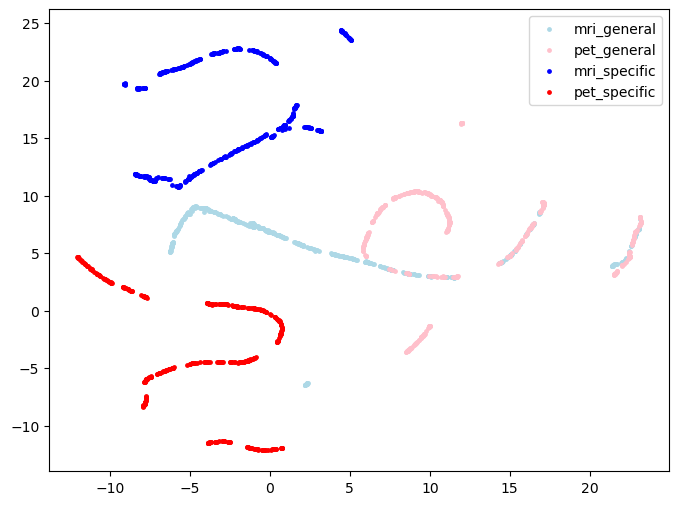

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(z_mri_general[:, 0], z_mri_general[:, 1], c='lightblue', s=6, label='mri_general')
plt.scatter(z_pet_general[:, 0], z_pet_general[:, 1], c='pink', s=6, label='pet_general')
plt.scatter(z_mri[:, 0], z_mri[:, 1], c='blue', s=6, label='mri_specific')
plt.scatter(z_pet[:, 0], z_pet[:, 1], c='red', s=6, label='pet_specific')
plt.legend(loc='best')
plt.show()

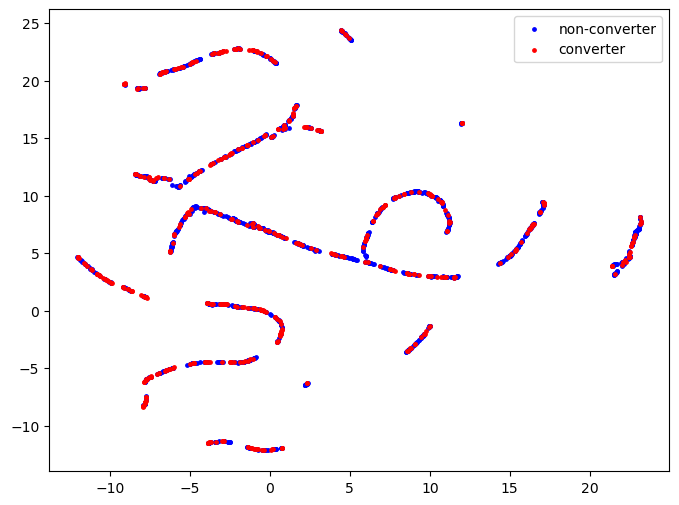

In [16]:
classes = [0, 1]
colors = ['blue', 'red']
plt.figure(figsize=(8, 6))
plt.scatter(embedding[Z['y'].repeat(4) == 0, 0], embedding[Z['y'].repeat(4) == 0, 1],
            c='blue', s=6, label='non-converter')
plt.scatter(embedding[Z['y'].repeat(4) == 1, 0], embedding[Z['y'].repeat(4) == 1, 1],
            c='red', s=6, label='converter')
plt.legend()
plt.show()